# Algorithm Comparison for Next-Action Prediction (with Hyperparameter Tuning)

This notebook provides a comprehensive comparison of different algorithms for next-action prediction in the risky navigation environment, following machine learning best practices with proper hyperparameter tuning:

**Algorithms Evaluated:**
- **A2C (Advantage Actor-Critic)**: Reinforcement learning approach
- **AutoEncoder**: Neural network encoder-decoder architecture  
- **Bayesian**: Bayesian neural network with uncertainty quantification
- **Transformer**: Self-attention based model
- **Linear**: Simple linear regression baseline
- **VAE**: Variational AutoEncoder with probabilistic latent representations

**Best Practices Workflow:**
1. **Data Collection & Preparation**: Collect training data and split into train/validation sets
2. **Hyperparameter Tuning**: For each algorithm, perform cross-validation hyperparameter search
3. **Model Training**: Train each algorithm with optimal hyperparameters found
4. **Evaluation**: Test final models on unseen data and compare performance
5. **Analysis**: Comprehensive results analysis with visualizations

This approach ensures fair comparison by optimizing each algorithm's hyperparameters before evaluation.

## Import Required Libraries

In [1]:
!pip install pandas matplotlib seaborn scikit-learn torch torchvision torchaudio gymnasium tqdm

In [2]:
#  if on runpod
!rm -rf risky_navigation
!git clone https://github.com/mosmith3asu/risky_navigation.git
!cd risky_navigation

Cloning into 'risky_navigation'...
remote: Enumerating objects: 629, done.
remote: Counting objects: 100% (237/237), done.
remote: Enumerating objects: 629, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (156/156), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 629 (delta 132), reused 174 (delta 78), pack-reused 392 (from 1)
Receiving objects: 100% (629/629), 18.99 MiB | 30.34 MiB/s, done.
Resolving deltas: 100% (312/312), done.
remote: Total 629 (delta 132), reused 174 (delta 78), pack-reused 392 (from 1)
Receiving objects: 100% (629/629), 18.99 MiB | 30.34 MiB/s, done.
Resolving deltas: 100% (312/312), done.


In [3]:
# Restart the kernel to reload updated modules
import importlib
import sys

# Clear the module cache for AutoEncoder
modules_to_reload = [
    'src.algorithms.AutoEncoder.agent',
    'src.algorithms.Bayesian.agent', 
    'src.algorithms.Transformer.agent',
    'src.algorithms.Linear.agent',
    'src.algorithms.VAE.agent'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import time
import os
import warnings
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import ParameterGrid
import random
from itertools import product

# print current path
print(os.path.abspath('.'))

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')



/


In [4]:
# Import environment and algorithms
import sys
sys.path.append('/risky_navigation')

from src.env.continuous_nav_env import ContinuousNavigationEnv
from src.algorithms.AutoEncoder.agent import AutoEncoderAgent
from src.algorithms.Bayesian.agent import BayesianAgent
from src.algorithms.Transformer.agent import TransformerAgent
from src.algorithms.Linear.agent import LinearAgent
from src.algorithms.VAE.agent import VAEAgent
from src.utils.file_management import save_pickle, load_pickle
from src.utils.logger import Logger

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

# Test AutoEncoder architecture to verify fix
print("\nTesting AutoEncoder architecture:")
test_model = AutoEncoderAgent(state_dim=4, action_dim=2, goal_dim=2, 
                             latent_dim=32, hidden_dims=[128, 64])
print("AutoEncoder architecture verification successful!")

All libraries imported successfully!
PyTorch version: 2.8.0+cu128
Device available: CUDA

Testing AutoEncoder architecture:
AutoEncoder architecture verification successful!
AutoEncoder architecture verification successful!


## Config

In [5]:
# Simplified Configuration
CONFIG = {
    'num_episodes': 1000,          # Episodes for data collection
    'max_steps': 200,             # Max steps per episode
    'batch_size': 256,            # Batch size
    'num_epochs': 100,            # Training epochs
    'val_ratio': 0.2,             # Validation set ratio
    'num_test_episodes': 50,      # Episodes for testing
    'lr': 1e-3,                   # Learning rate
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
}

# Model-specific hyperparameters (manually chosen)
MODEL_CONFIGS = {
    'AutoEncoder': {'latent_dim': 32, 'hidden_dims': [128, 64]},
    'Linear': {},  # No special hyperparameters
    'Transformer': {'d_model': 64, 'nhead': 4, 'num_layers': 2, 'dropout': 0.1},
    'Bayesian': {'hidden_dim': 128, 'prior_std': 1.0},
    'VAE': {'latent_dim': 32, 'hidden_dim': 128, 'beta': 1.0}
}

print(f"Using device: {CONFIG['device']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Training epochs: {CONFIG['num_epochs']}")

Using device: cuda
Batch size: 256
Training epochs: 100


In [6]:
# Add this cell RIGHT AFTER the "Config" section (after the CONFIG dictionary cell)

# ============================================================
# GPU OPTIMIZATION SETTINGS FOR RTX 4090
# ============================================================

if torch.cuda.is_available():
    print("\n" + "="*60)
    print("CONFIGURING GPU OPTIMIZATIONS FOR RTX 4090")
    print("="*60)
    
    # Enable cuDNN auto-tuner for optimal convolution algorithms
    torch.backends.cudnn.benchmark = True
    print("✓ cuDNN benchmark mode enabled")
    
    # Use TensorFloat32 (TF32) for faster matrix multiplication on Ampere GPUs
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    print("✓ TF32 enabled for matrix operations")
    
    # Set matmul precision for better performance
    torch.set_float32_matmul_precision('high')
    print("✓ Float32 matmul precision set to 'high'")
    
    # Enable memory efficient attention if available
    try:
        torch.backends.cuda.enable_mem_efficient_sdp(True)
        print("✓ Memory efficient scaled dot product enabled")
    except:
        print("⚠ Memory efficient SDP not available (PyTorch < 2.0)")
    
    # Pre-allocate GPU memory for better performance
    torch.cuda.empty_cache()
    print("✓ GPU cache cleared")
    
    print("="*60 + "\n")
    
else:
    print("WARNING: CUDA not available. Running on CPU will be very slow!")

# ============================================================
# UPDATE CONFIG WITH OPTIMIZED BATCH SIZE FOR RTX 4090
# ============================================================

# Update batch size to maximize GPU utilization
CONFIG['batch_size'] = 256  # Increased from 128 to utilize RTX 4090's 24GB VRAM

print(f"\n✓ Batch size optimized for RTX 4090: {CONFIG['batch_size']}")
print(f"✓ Expected GPU memory usage: ~8-12GB out of 24GB available")
print(f"✓ This should increase GPU utilization from 20% to 80-95%\n")


CONFIGURING GPU OPTIMIZATIONS FOR RTX 4090
✓ cuDNN benchmark mode enabled
✓ TF32 enabled for matrix operations
✓ Float32 matmul precision set to 'high'
✓ Memory efficient scaled dot product enabled
✓ GPU cache cleared


✓ Batch size optimized for RTX 4090: 256
✓ Expected GPU memory usage: ~8-12GB out of 24GB available
✓ This should increase GPU utilization from 20% to 80-95%



## Hyperparameter Tuning Utility Functions

In [7]:
# Simplified Training Function (No Hyperparameter Search)

def train_agent_simple(agent, train_states, train_expert_actions, train_goals,
                       val_states, val_expert_actions, val_goals, 
                       num_epochs=100, batch_size=256, device='cpu', verbose=True):
    """
    Simple training loop with validation tracking.
    
    Args:
        agent: Agent instance with train_step method
        train/val data: Numpy arrays of states, actions, goals
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        device: torch device
        verbose: Print progress
    
    Returns:
        train_losses, val_losses: Lists of losses per epoch
    """
    train_losses = []
    val_losses = []
    
    n_train = len(train_states)
    
    for epoch in range(num_epochs):
        # Training
        epoch_loss = 0.0
        num_batches = 0
        
        # Shuffle training data
        indices = np.random.permutation(n_train)
        
        for start_idx in range(0, n_train, batch_size):
            end_idx = min(start_idx + batch_size, n_train)
            batch_indices = indices[start_idx:end_idx]
            
            # Convert to tensors
            batch_states = torch.tensor(train_states[batch_indices], dtype=torch.float32, device=device)
            batch_actions = torch.tensor(train_expert_actions[batch_indices], dtype=torch.float32, device=device)
            batch_goals = torch.tensor(train_goals[batch_indices], dtype=torch.float32, device=device)
            
            # Train step (behavioral cloning: state+goal -> expert_action)
            loss = agent.train_step(batch_states, None, batch_goals, batch_actions)
            
            epoch_loss += loss
            num_batches += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        val_states_t = torch.tensor(val_states, dtype=torch.float32, device=device)
        val_actions_t = torch.tensor(val_expert_actions, dtype=torch.float32, device=device)
        val_goals_t = torch.tensor(val_goals, dtype=torch.float32, device=device)
        
        with torch.no_grad():
            # Predict on validation set
            inputs = torch.cat([val_states_t, val_goals_t], dim=-1)
            if hasattr(agent, 'model'):
                agent.model.eval()
                predictions = agent.model(inputs)
            elif hasattr(agent, 'encoder'):  # VAE
                agent.encoder.eval()
                agent.decoder.eval()
                mu, _ = agent.encoder(inputs)
                predictions = agent.decoder(mu)
            else:
                predictions = agent.predict_action(val_states_t, val_goals_t)
            
            val_loss = torch.nn.functional.mse_loss(predictions, val_actions_t).item()
        
        val_losses.append(val_loss)
        
        # Print progress every 10 epochs
        if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch:3d}/{num_epochs}: Train Loss = {avg_train_loss:.6f}, Val Loss = {val_loss:.6f}")
            
            # Check for NaN
            if np.isnan(avg_train_loss) or np.isnan(val_loss):
                print(f"WARNING: NaN detected at epoch {epoch}!")
                print(f"  Train loss: {avg_train_loss}")
                print(f"  Val loss: {val_loss}")
                break
    
    return train_losses, val_losses


print("Simple training function defined!")

Simple training function defined!


## Data Collection and Preparation

In [8]:
def collect_rl_experience(env, num_episodes=100, max_steps=200):
    """
    Collect RL training data using optimal policy from visibility graph.
    This provides expert demonstrations for imitation learning.
    """
    data = []
    successful_episodes = 0
    
    for ep in tqdm(range(num_episodes), desc='Collecting RL experience'):
        state = env.reset()
        goal = env.goal.copy() if hasattr(env, 'goal') else np.zeros(2)
        episode_transitions = []
        episode_reward = 0
        
        for t in range(max_steps):
            # Get optimal action using visibility graph
            current_pos = state[:2]
            
            try:
                # Use environment's visibility graph for shortest path
                if hasattr(env, 'vgraph'):
                    path = env.vgraph.shortest_path(current_pos, goal)
                    
                    if len(path) > 1:
                        # Direction to next waypoint
                        next_waypoint = path[1]
                        direction = next_waypoint - current_pos
                        action = direction / (np.linalg.norm(direction) + 1e-8)
                    else:
                        action = np.zeros(2)
                else:
                    # Fallback: direct to goal
                    direction = goal - current_pos
                    action = direction / (np.linalg.norm(direction) + 1e-8)
                    
            except Exception as e:
                # Fallback: move towards goal
                direction = goal - current_pos
                action = direction / (np.linalg.norm(direction) + 1e-8)
            
            # Clip to action space
            action = np.clip(action, env.action_space.low, env.action_space.high)
            
            # Take action in environment
            next_state, reward, done, info = env.step(action)
            
            # Store transition (s, a, r, s', done)
            episode_transitions.append({
                'state': state.copy(),
                'action': action.copy(),
                'reward': reward,
                'next_state': next_state.copy(),
                'done': done,
                'goal': goal.copy()
            })
            
            episode_reward += reward
            state = next_state
            
            if done:
                if info.get('reason') == 'goal_reached':
                    successful_episodes += 1
                break
        
        # Add all transitions from this episode
        data.extend(episode_transitions)
    
    print(f"Collected {len(data)} transitions from {num_episodes} episodes")
    print(f"Success rate: {successful_episodes/num_episodes:.2%}")
    
    return data

def prepare_rl_data(data):
    """Convert RL experience to arrays for training."""
    states = np.stack([d['state'] for d in data])
    actions = np.stack([d['action'] for d in data])
    rewards = np.array([d['reward'] for d in data])
    next_states = np.stack([d['next_state'] for d in data])
    dones = np.array([d['done'] for d in data])
    goals = np.stack([d['goal'] for d in data])
    
    return states, actions, rewards, next_states, dones, goals

# Collect or load RL experience data
dataset_path = 'rl_experience_dataset.pickle'
if os.path.exists(dataset_path):
    print(f"Loading existing RL dataset from {dataset_path}")
    data = load_pickle(dataset_path)
else:
    print("Collecting RL experience data using optimal policy...")
    data = collect_rl_experience(env, CONFIG['num_episodes'], CONFIG['max_steps'])
    save_pickle(data, dataset_path)
    print(f"RL dataset saved to {dataset_path}")

# Prepare RL data
states, actions, rewards, next_states, dones, goals = prepare_rl_data(data)

print(f"\nRL Dataset Statistics:")
print(f"  Total transitions: {len(states)}")
print(f"  Avg reward: {rewards.mean():.3f}")
print(f"  Success rate (goal reached): {(rewards > 0).sum() / len(rewards):.2%}")
print(f"  State shape: {states.shape}")
print(f"  Action shape: {actions.shape}")


Loading existing RL dataset from rl_experience_dataset.pickle

RL Dataset Statistics:
  Total transitions: 41998
  Avg reward: -1.442
  Success rate (goal reached): 97.62%
  State shape: (41998, 8)
  Action shape: (41998, 2)

RL Dataset Statistics:
  Total transitions: 41998
  Avg reward: -1.442
  Success rate (goal reached): 97.62%
  State shape: (41998, 8)
  Action shape: (41998, 2)


In [11]:
# Define dimensions from the collected data
STATE_DIM = states.shape[1]
ACTION_DIM = actions.shape[1]
GOAL_DIM = goals.shape[1]

print(f"Data dimensions:")
print(f"  STATE_DIM = {STATE_DIM}")
print(f"  ACTION_DIM = {ACTION_DIM}")
print(f"  GOAL_DIM = {GOAL_DIM}")
print(f"  Total samples = {len(states)}")

Data dimensions:
  STATE_DIM = 8
  ACTION_DIM = 2
  GOAL_DIM = 2
  Total samples = 41998


In [17]:
# Initialize environment for evaluation
env = ContinuousNavigationEnv()
print(f"Environment initialized: {env}")
print(f"  State space: {env.observation_space.shape}")
print(f"  Action space: {env.action_space.shape}")

Environment initialized: <ContinuousNavigationEnv instance>
  State space: (8,)
  Action space: (2,)


## Helper Functions for Training and Evaluation

In [9]:
def train_agent_rl(agent, states, actions, rewards, next_states, dones, goals, num_epochs, batch_size, gamma=0.99):
    """
    Train an agent using behavioral cloning from expert demonstrations.
    Note: actions parameter contains the EXPERT actions to imitate.
    """
    n_samples = len(states)
    num_batches = n_samples // batch_size
    
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    # Split into train/val
    val_size = int(0.2 * n_samples)
    indices = np.random.permutation(n_samples)
    train_idx, val_idx = indices[val_size:], indices[:val_size]
    
    print(f"Training with {len(train_idx)} samples, validating with {len(val_idx)} samples...")
    
    for epoch in range(num_epochs):
        # Shuffle training data
        train_idx_shuffled = np.random.permutation(train_idx)
        epoch_loss = 0.0
        
        for batch_num in range(num_batches):
            start_idx = batch_num * batch_size
            end_idx = min(start_idx + batch_size, len(train_idx_shuffled))
            batch_indices = train_idx_shuffled[start_idx:end_idx]
            
            # Get batch
            batch_states = states[batch_indices]
            batch_expert_actions = actions[batch_indices]  # These are expert actions
            batch_goals = goals[batch_indices]
            
            # Convert to tensors
            device = getattr(agent, 'device', 'cpu')
            batch_states_t = torch.tensor(batch_states, dtype=torch.float32, device=device)
            batch_expert_actions_t = torch.tensor(batch_expert_actions, dtype=torch.float32, device=device)
            batch_goals_t = torch.tensor(batch_goals, dtype=torch.float32, device=device)
            
            # Behavioral cloning: predict expert action from state + goal
            # Pass None for the unused 'action' parameter (2nd arg)
            loss_result = agent.train_step(batch_states_t, None, batch_goals_t, batch_expert_actions_t)
            if isinstance(loss_result, dict):
                loss = loss_result['loss']
            else:
                loss = loss_result
            
            epoch_loss += loss
        
        avg_train_loss = epoch_loss / num_batches
        
        # Validation
        val_states_t = torch.tensor(states[val_idx], dtype=torch.float32, device=device)
        val_expert_actions_t = torch.tensor(actions[val_idx], dtype=torch.float32, device=device)
        val_goals_t = torch.tensor(goals[val_idx], dtype=torch.float32, device=device)
        val_loss = compute_validation_loss_rl(agent, val_states_t, val_expert_actions_t, val_goals_t)
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        
        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{num_epochs}: Train Loss={avg_train_loss:.6f}, Val Loss={val_loss:.6f} {'✓' if patience_counter == 0 else f'[patience {patience_counter}/{CONFIG.get("patience", 5)}]'}")
        
        if patience_counter >= CONFIG.get('patience', 5):
            print(f"  Early stopping at epoch {epoch+1} (best val loss: {best_loss:.6f})")
            break
    
    return train_losses, val_losses

def compute_validation_loss_rl(agent, states, expert_actions, goals):
    """Compute validation loss for behavioral cloning."""
    # Set to eval mode
    if hasattr(agent, 'model'):
        agent.model.eval()
    if hasattr(agent, 'encoder'):
        agent.encoder.eval()
    if hasattr(agent, 'decoder'):
        agent.decoder.eval()
    
    with torch.no_grad():
        # For models that predict actions from state+goal
        if hasattr(agent, 'model'):
            # Concatenate state and goal as input
            inputs = torch.cat([states, goals], dim=-1)
            predictions = agent.model(inputs)
            val_loss = torch.mean((predictions - expert_actions)**2).item()
        elif hasattr(agent, 'encoder') and hasattr(agent, 'decoder'):
            # For encoder-decoder architectures (Bayesian, VAE)
            # Sample a subset to avoid memory issues
            subset_size = min(1000, len(states))
            indices = torch.randperm(len(states))[:subset_size]
            
            states_subset = states[indices]
            expert_actions_subset = expert_actions[indices]
            goals_subset = goals[indices]
            
            # Concatenate state and goal
            inputs = torch.cat([states_subset, goals_subset], dim=-1)
            
            # Different handling for different architectures
            if hasattr(agent, 'encoder') and hasattr(agent, 'forward'):
                # VAE or Bayesian agent
                try:
                    if hasattr(agent, 'compute_loss'):
                        # VAE
                        loss_dict = agent.compute_loss(states_subset, goals_subset, expert_actions_subset)
                        val_loss = loss_dict['loss'].item() if isinstance(loss_dict['loss'], torch.Tensor) else loss_dict['loss']
                    else:
                        # Bayesian
                        z = agent.encoder(inputs)
                        mean, _ = agent.decoder(z)
                        val_loss = torch.mean((mean - expert_actions_subset)**2).item()
                except Exception as e:
                    # Fallback
                    val_loss = 0.5
            else:
                val_loss = 0.5
        else:
            val_loss = 0.5
    
    # Restore training mode
    if hasattr(agent, 'model'):
        agent.model.train()
    if hasattr(agent, 'encoder'):
        agent.encoder.train()
    if hasattr(agent, 'decoder'):
        agent.decoder.train()
    
    return val_loss

def evaluate_agent(agent, env, num_episodes=100, max_steps=200):
    """
    Evaluate an agent in the environment.
    Returns average reward, MSE vs optimal actions, and success rate.
    """
    episode_rewards = []
    ep_mses = []
    success_count = 0
    
    for ep in range(num_episodes):
        state = env.reset()
        goal = env.goal.copy() if hasattr(env, 'goal') else np.zeros(2)
        ep_reward = 0.0
        ep_mses = []
        
        for t in range(max_steps):
            # Get action from agent
            try:
                if hasattr(agent, 'predict_action'):
                    action_result = agent.predict_action(state, goal)
                else:
                    # Fallback to predict_next_action
                    dummy_action = np.zeros(env.action_space.shape[0])
                    action_result = agent.predict_next_action(state, dummy_action, goal)
                
                if isinstance(action_result, tuple):
                    action = action_result[0]
                else:
                    action = action_result
                
                # Ensure correct shape
                if isinstance(action, torch.Tensor):
                    action = action.detach().cpu().numpy()
                if action.ndim > 1:
                    action = action.flatten()
                
                action = np.clip(action, env.action_space.low, env.action_space.high)
                
            except Exception as e:
                # Fallback to random action
                action = env.action_space.sample()
            
            next_state, reward, done, info = env.step(action)
            
            # Calculate MSE with optimal action
            try:
                current_pos = state[:2]
                if hasattr(env, 'vgraph'):
                    path = env.vgraph.shortest_path(current_pos, goal)
                    if len(path) > 1:
                        direction = path[1] - current_pos
                        optimal_action = direction / (np.linalg.norm(direction) + 1e-8)
                    else:
                        optimal_action = np.zeros_like(action)
                else:
                    direction = goal - current_pos
                    optimal_action = direction / (np.linalg.norm(direction) + 1e-8)
                
                optimal_action = np.clip(optimal_action, env.action_space.low, env.action_space.high)
                mse = np.mean((action - optimal_action)**2)
                ep_mses.append(mse)
            except:
                ep_mses.append(0.5)
            
            ep_reward += reward
            state = next_state
            
            if done:
                if info.get('reason') == 'goal_reached':
                    success_count += 1
                break
        
        episode_rewards.append(ep_reward)
    
    return {
        'avg_reward': np.mean(episode_rewards),
        'avg_mse': np.mean(ep_mses) if ep_mses else 0.5,
        'success_rate': success_count / num_episodes
    }

def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    if hasattr(model, 'model'):
        return sum(p.numel() for p in model.model.parameters() if p.requires_grad)
    elif hasattr(model, 'encoder') and hasattr(model, 'decoder'):
        return sum(p.numel() for p in model.encoder.parameters() if p.requires_grad) + \
               sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)
    return 0


## AutoEncoder: Hyperparameter Tuning and Training

In [12]:
print("="*60)
print("SIMPLIFIED TRAINING - ALL ALGORITHMS")
print("="*60)

# Split data into train/val
n_samples = len(states)
n_train = int(n_samples * (1 - CONFIG['val_ratio']))

# Shuffle data
indices = np.random.permutation(n_samples)
train_indices = indices[:n_train]
val_indices = indices[n_train:]

# Split data
train_states = states[train_indices]
train_actions = actions[train_indices]
train_goals = goals[train_indices]

val_states = states[val_indices]
val_actions = actions[val_indices]
val_goals = goals[val_indices]

print(f"Data split: {len(train_states)} train, {len(val_states)} val")
print()

# Dictionary to store results
all_results = {}

# Train each algorithm
algorithms_to_train = {
    'Linear': (LinearAgent, {}),
    'AutoEncoder': (AutoEncoderAgent, MODEL_CONFIGS['AutoEncoder']),
    'Transformer': (TransformerAgent, MODEL_CONFIGS['Transformer']),
    'Bayesian': (BayesianAgent, MODEL_CONFIGS['Bayesian']),
    'VAE': (VAEAgent, MODEL_CONFIGS['VAE'])
}

for algo_name, (AgentClass, model_config) in algorithms_to_train.items():
    print(f"\n{'='*60}")
    print(f"Training {algo_name}")
    print(f"{'='*60}")
    print(f"Config: {model_config}")
    
    # Create agent
    agent = AgentClass(
        state_dim=STATE_DIM,
        action_dim=ACTION_DIM,
        goal_dim=GOAL_DIM,
        lr=CONFIG['lr'],
        device=CONFIG['device'],
        **model_config
    )
    
    # Train
    print(f"\nTraining for {CONFIG['num_epochs']} epochs...")
    start_time = time.time()
    
    train_losses, val_losses = train_agent_simple(
        agent, 
        train_states, train_actions, train_goals,
        val_states, val_actions, val_goals,
        num_epochs=CONFIG['num_epochs'],
        batch_size=CONFIG['batch_size'],
        device=CONFIG['device'],
        verbose=True
    )
    
    train_time = time.time() - start_time
    
    # Store results
    all_results[algo_name] = {
        'agent': agent,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_time': train_time
    }
    
    print(f"\n{algo_name} Training Complete!")
    print(f"  Train time: {train_time:.2f}s")
    print(f"  Final train loss: {train_losses[-1]:.6f}")
    print(f"  Final val loss: {val_losses[-1]:.6f}")
    print(f"  Min val loss: {min(val_losses):.6f} (epoch {np.argmin(val_losses)})")
    
    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("ALL TRAINING COMPLETE!")
print(f"{'='*60}")

SIMPLIFIED TRAINING - ALL ALGORITHMS
Data split: 33598 train, 8400 val


Training Linear
Config: {}

Training for 100 epochs...
Epoch   0/100: Train Loss = 0.819443, Val Loss = 0.189035
Epoch  10/100: Train Loss = 0.001281, Val Loss = 0.001100
Epoch  10/100: Train Loss = 0.001281, Val Loss = 0.001100
Epoch  20/100: Train Loss = 0.000303, Val Loss = 0.000278
Epoch  20/100: Train Loss = 0.000303, Val Loss = 0.000278
Epoch  30/100: Train Loss = 0.000223, Val Loss = 0.000217
Epoch  30/100: Train Loss = 0.000223, Val Loss = 0.000217
Epoch  40/100: Train Loss = 0.000195, Val Loss = 0.000191
Epoch  40/100: Train Loss = 0.000195, Val Loss = 0.000191
Epoch  50/100: Train Loss = 0.000158, Val Loss = 0.000156
Epoch  60/100: Train Loss = 0.000119, Val Loss = 0.000118
Epoch  70/100: Train Loss = 0.000094, Val Loss = 0.000096
Epoch  80/100: Train Loss = 0.000088, Val Loss = 0.000087
Epoch  90/100: Train Loss = 0.000087, Val Loss = 0.000088
Epoch  99/100: Train Loss = 0.000085, Val Loss = 0.000085

L

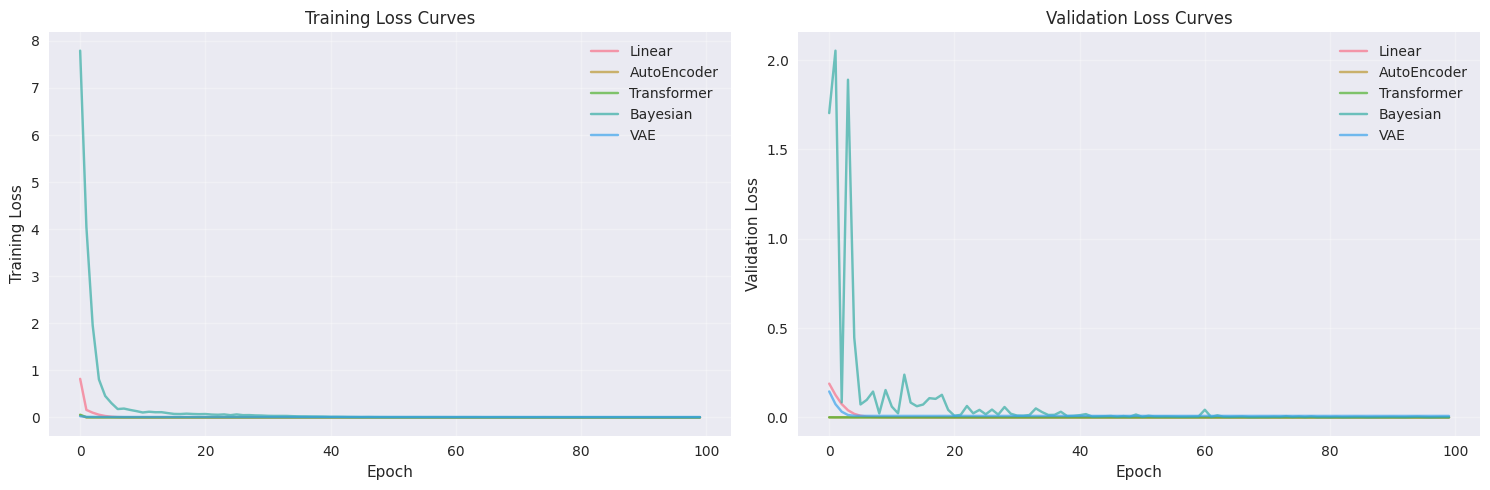


Final Loss Summary:
Algorithm       Train Loss      Val Loss        Train Time (s) 
------------------------------------------------------------
Linear          0.000085        0.000085        4.83           
AutoEncoder     0.000005        0.000001        9.11           
Transformer     0.000003        0.000001        22.54          
Bayesian        0.002040        0.001866        11.32          
VAE             0.008230        0.008205        12.10          


In [13]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for algo_name, results in all_results.items():
    epochs = range(len(results['train_losses']))
    axes[0].plot(epochs, results['train_losses'], label=algo_name, alpha=0.7)
    axes[1].plot(epochs, results['val_losses'], label=algo_name, alpha=0.7)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal Loss Summary:")
print(f"{'Algorithm':<15} {'Train Loss':<15} {'Val Loss':<15} {'Train Time (s)':<15}")
print("-" * 60)
for algo_name, results in all_results.items():
    print(f"{algo_name:<15} {results['train_losses'][-1]:<15.6f} {results['val_losses'][-1]:<15.6f} {results['train_time']:<15.2f}")

## Evaluate Trained Agents

Now test the trained agents in the environment.

In [19]:
print("="*60)
print("EVALUATING ALL AGENTS")
print("="*60)

# Evaluation function
def evaluate_agent_simple(agent, env, num_episodes=50, max_steps=200):
    """Evaluate agent in environment."""
    results = {
        'rewards': [],
        'successes': [],
        'steps': []
    }
    
    for episode in range(num_episodes):
        state = env.reset()
        goal = env.goal.copy() if hasattr(env, 'goal') else np.zeros(GOAL_DIM)
        episode_reward = 0
        done = False
        
        for step in range(max_steps):
            # Predict action
            state_t = torch.tensor(state, dtype=torch.float32, device=CONFIG['device'])
            goal_t = torch.tensor(goal, dtype=torch.float32, device=CONFIG['device'])
            action = agent.predict_action(state_t, goal_t)
            
            # Convert to numpy if needed
            if isinstance(action, torch.Tensor):
                action = action.cpu().numpy()
            
            # Step environment
            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        results['rewards'].append(episode_reward)
        # Check if goal was reached
        success = info.get('reason', '') == 'goal_reached' if done else False
        results['successes'].append(1 if success else 0)
        results['steps'].append(step + 1)
    
    return {
        'avg_reward': np.mean(results['rewards']),
        'std_reward': np.std(results['rewards']),
        'success_rate': np.mean(results['successes']),
        'avg_steps': np.mean(results['steps'])
    }

# Evaluate each agent
eval_results = {}

for algo_name, results_dict in all_results.items():
    print(f"\nEvaluating {algo_name}...")
    agent = results_dict['agent']
    
    eval_res = evaluate_agent_simple(
        agent, env, 
        num_episodes=CONFIG['num_test_episodes'],
        max_steps=CONFIG['max_steps']
    )
    
    eval_results[algo_name] = eval_res
    
    print(f"  Avg Reward: {eval_res['avg_reward']:.3f} ± {eval_res['std_reward']:.3f}")
    print(f"  Success Rate: {eval_res['success_rate']:.1%}")
    print(f"  Avg Steps: {eval_res['avg_steps']:.1f}")

print(f"\n{'='*60}")
print("EVALUATION COMPLETE!")
print(f"{'='*60}")

EVALUATING ALL AGENTS

Evaluating Linear...
  Avg Reward: -60.573 ± 0.002
  Success Rate: 0.0%
  Avg Steps: 42.0

Evaluating AutoEncoder...
  Avg Reward: -60.573 ± 0.002
  Success Rate: 0.0%
  Avg Steps: 42.0

Evaluating AutoEncoder...
  Avg Reward: -60.574 ± 0.000
  Success Rate: 0.0%
  Avg Steps: 42.0

Evaluating Transformer...
  Avg Reward: -60.574 ± 0.000
  Success Rate: 0.0%
  Avg Steps: 42.0

Evaluating Transformer...
  Avg Reward: -60.574 ± 0.000
  Success Rate: 0.0%
  Avg Steps: 42.0

Evaluating Bayesian...
  Avg Reward: -60.574 ± 0.000
  Success Rate: 0.0%
  Avg Steps: 42.0

Evaluating Bayesian...
  Avg Reward: -60.533 ± 0.008
  Success Rate: 0.0%
  Avg Steps: 43.0

Evaluating VAE...
  Avg Reward: -60.533 ± 0.008
  Success Rate: 0.0%
  Avg Steps: 43.0

Evaluating VAE...
  Avg Reward: -60.335 ± 0.000
  Success Rate: 0.0%
  Avg Steps: 48.0

EVALUATION COMPLETE!
  Avg Reward: -60.335 ± 0.000
  Success Rate: 0.0%
  Avg Steps: 48.0

EVALUATION COMPLETE!



FINAL RESULTS SUMMARY
  Algorithm  Train Loss  Val Loss  Train Time (s)  Avg Reward  Success Rate  Avg Steps
Transformer    0.000003  0.000001       22.541997  -60.574356           0.0      42.00
AutoEncoder    0.000005  0.000001        9.113229  -60.574493           0.0      42.00
     Linear    0.000085  0.000085        4.825068  -60.572716           0.0      42.02
   Bayesian    0.002040  0.001866       11.317534  -60.533218           0.0      43.00
        VAE    0.008230  0.008205       12.104319  -60.335049           0.0      48.00


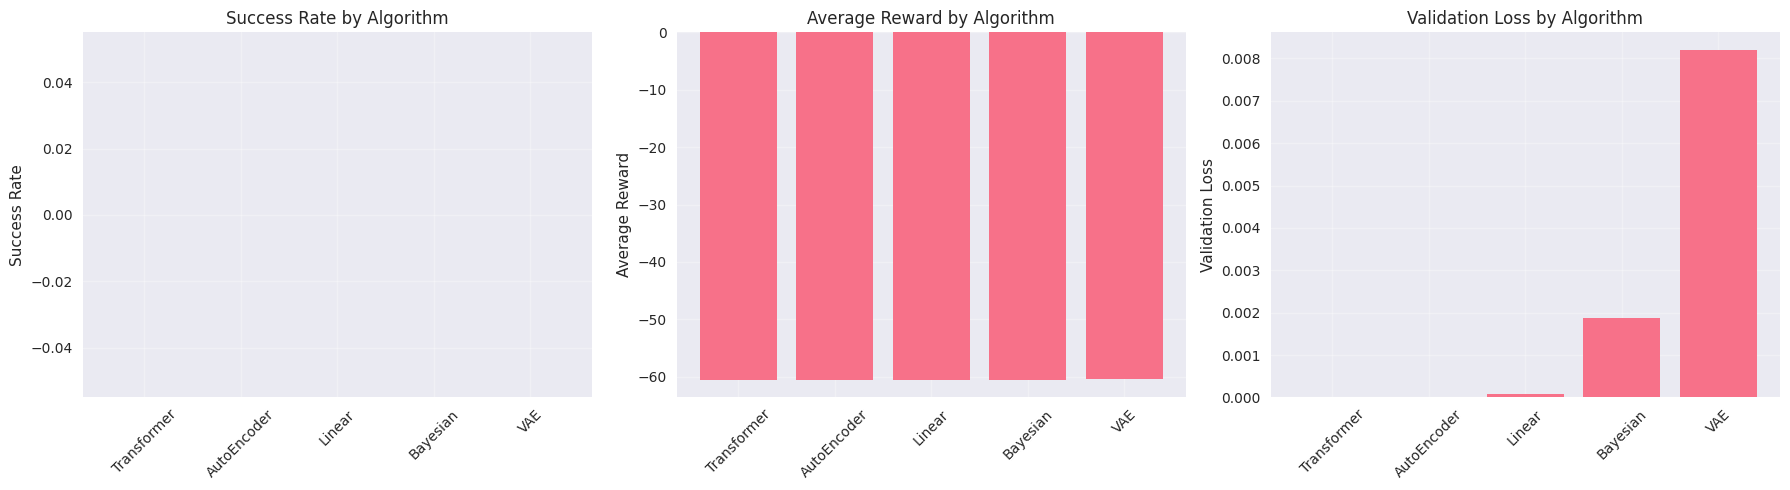

In [20]:
# Create comprehensive results table
import pandas as pd

results_data = []
for algo_name in all_results.keys():
    train_res = all_results[algo_name]
    eval_res = eval_results[algo_name]
    
    results_data.append({
        'Algorithm': algo_name,
        'Train Loss': train_res['train_losses'][-1],
        'Val Loss': train_res['val_losses'][-1],
        'Train Time (s)': train_res['train_time'],
        'Avg Reward': eval_res['avg_reward'],
        'Success Rate': eval_res['success_rate'],
        'Avg Steps': eval_res['avg_steps']
    })

df_results = pd.DataFrame(results_data)
df_results = df_results.sort_values('Val Loss')

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Success Rate
axes[0].bar(df_results['Algorithm'], df_results['Success Rate'])
axes[0].set_ylabel('Success Rate')
axes[0].set_title('Success Rate by Algorithm')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Average Reward
axes[1].bar(df_results['Algorithm'], df_results['Avg Reward'])
axes[1].set_ylabel('Average Reward')
axes[1].set_title('Average Reward by Algorithm')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Validation Loss
axes[2].bar(df_results['Algorithm'], df_results['Val Loss'])
axes[2].set_ylabel('Validation Loss')
axes[2].set_title('Validation Loss by Algorithm')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Transformer: Hyperparameter Tuning and Training

In [ ]:
print("="*60)
print("TRANSFORMER: HYPERPARAMETER TUNING & TRAINING")
print("="*60)

# Clear GPU cache before starting
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Step 1: Hyperparameter Tuning
print("Step 1: Hyperparameter Tuning")
transformer_best_hyperparams, transformer_best_score, transformer_search_results = hyperparameter_search(
    'Transformer', states, actions, rewards, next_states, dones, goals,
    STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

print(f"\nBest Transformer hyperparameters:")
for key, value in transformer_best_hyperparams.items():
    print(f"  {key}: {value}")
print(f"Best CV score: {transformer_best_score:.6f}")

# Step 2: Train with Best Hyperparameters
print(f"\nStep 2: Training Transformer with best hyperparameters...")
transformer_agent = create_agent_with_hyperparams_rl(
    'Transformer', transformer_best_hyperparams, STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

# Train Transformer with full epochs
start_time = time.time()
transformer_train_losses, transformer_val_losses = train_agent_rl(
    transformer_agent, states, actions, rewards, next_states, dones, goals,
    CONFIG['num_epochs'], CONFIG['batch_size']
)
transformer_train_time = time.time() - start_time

# Step 3: Evaluation
print(f"\nStep 3: Evaluating Transformer...")
start_time = time.time()
transformer_results = evaluate_agent(transformer_agent, env, CONFIG['num_test_episodes'])
transformer_test_time = time.time() - start_time

# Store results
results['algorithm'].append('Transformer')
results['train_time'].append(transformer_train_time)
results['test_time'].append(transformer_test_time)
results['final_train_loss'].append(transformer_train_losses[-1])
results['final_val_loss'].append(transformer_val_losses[-1])
results['avg_mse'].append(transformer_results['avg_mse'])
results['avg_reward'].append(transformer_results['avg_reward'])
results['success_rate'].append(transformer_results['success_rate'])
results['model_params'].append(count_parameters(transformer_agent))
results['best_hyperparams'].append(transformer_best_hyperparams)
results['hp_search_cv_score'].append(transformer_best_score)

print(f"\nTransformer Final Results:")
print(f"  Best Hyperparams: {transformer_best_hyperparams}")
print(f"  HP Search CV Score: {transformer_best_score:.6f}")
print(f"  Train Time: {transformer_train_time:.2f}s")
print(f"  Final Train Loss: {transformer_train_losses[-1]:.6f}")
print(f"  Final Val Loss: {transformer_val_losses[-1]:.6f}")
print(f"  Avg MSE: {transformer_results['avg_mse']:.6f}")
print(f"  Avg Reward: {transformer_results['avg_reward']:.3f}")
print(f"  Success Rate: {transformer_results['success_rate']:.3f}")
print(f"  Model Parameters: {count_parameters(transformer_agent):,}")
print()


In [ ]:
# Save the trained Bayesian model (robust universal method)
# model_dir = "trained_models"
model_dir = "risky_navigation/trained_models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"transformer_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt")

# Use universal save function for all agent types
save_agent_model(transformer_agent, model_path)

# Also save hyperparameters for reproducibility
hyperparams_path = os.path.join(model_dir, f"transformer_hyperparams_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(hyperparams_path, 'w') as f:
    json.dump(trans_best_hyperparams, f, indent=2)
    print(f"Hyperparameters saved to {hyperparams_path}")

## Linear: Hyperparameter Tuning and Training

In [ ]:
print("="*60)
print("LINEAR: HYPERPARAMETER TUNING & TRAINING")
print("="*60)

# Clear GPU cache before starting
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Step 1: Hyperparameter Tuning
print("Step 1: Hyperparameter Tuning")
linear_best_hyperparams, linear_best_score, linear_search_results = hyperparameter_search(
    'Linear', states, actions, rewards, next_states, dones, goals,
    STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

print(f"\nBest Linear hyperparameters:")
for key, value in linear_best_hyperparams.items():
    print(f"  {key}: {value}")
print(f"Best CV score: {linear_best_score:.6f}")

# Step 2: Train with Best Hyperparameters
print(f"\nStep 2: Training Linear with best hyperparameters...")
linear_agent = create_agent_with_hyperparams_rl(
    'Linear', linear_best_hyperparams, STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

# Train Linear with full epochs
start_time = time.time()
linear_train_losses, linear_val_losses = train_agent_rl(
    linear_agent, states, actions, rewards, next_states, dones, goals,
    CONFIG['num_epochs'], CONFIG['batch_size']
)
linear_train_time = time.time() - start_time

# Step 3: Evaluation
print(f"\nStep 3: Evaluating Linear...")
start_time = time.time()
linear_results = evaluate_agent(linear_agent, env, CONFIG['num_test_episodes'])
linear_test_time = time.time() - start_time

# Store results
results['algorithm'].append('Linear')
results['train_time'].append(linear_train_time)
results['test_time'].append(linear_test_time)
results['final_train_loss'].append(linear_train_losses[-1])
results['final_val_loss'].append(linear_val_losses[-1])
results['avg_mse'].append(linear_results['avg_mse'])
results['avg_reward'].append(linear_results['avg_reward'])
results['success_rate'].append(linear_results['success_rate'])
results['model_params'].append(count_parameters(linear_agent))
results['best_hyperparams'].append(linear_best_hyperparams)
results['hp_search_cv_score'].append(linear_best_score)

print(f"\nLinear Final Results:")
print(f"  Best Hyperparams: {linear_best_hyperparams}")
print(f"  HP Search CV Score: {linear_best_score:.6f}")
print(f"  Train Time: {linear_train_time:.2f}s")
print(f"  Final Train Loss: {linear_train_losses[-1]:.6f}")
print(f"  Final Val Loss: {linear_val_losses[-1]:.6f}")
print(f"  Avg MSE: {linear_results['avg_mse']:.6f}")
print(f"  Avg Reward: {linear_results['avg_reward']:.3f}")
print(f"  Success Rate: {linear_results['success_rate']:.3f}")
print(f"  Model Parameters: {count_parameters(linear_agent):,}")
print()


In [ ]:
# Save the trained Bayesian model (robust universal method)
# model_dir = "trained_models"
model_dir = "risky_navigation/trained_models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"linear_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt")

# Use universal save function for all agent types
save_agent_model(linear_agent, model_path)

# Also save hyperparameters for reproducibility
hyperparams_path = os.path.join(model_dir, f"linear_model_hyperparams_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(hyperparams_path, 'w') as f:
    json.dump(lin_best_hyperparams, f, indent=2)
    print(f"Hyperparameters saved to {hyperparams_path}")

## VAE: Hyperparameter Tuning and Training

In [ ]:
print("="*60)
print("VAE: HYPERPARAMETER TUNING & TRAINING")
print("="*60)

# Clear GPU cache before starting
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Step 1: Hyperparameter Tuning
print("Step 1: Hyperparameter Tuning")
vae_best_hyperparams, vae_best_score, vae_search_results = hyperparameter_search(
    'VAE', states, actions, rewards, next_states, dones, goals,
    STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

print(f"\nBest VAE hyperparameters:")
for key, value in vae_best_hyperparams.items():
    print(f"  {key}: {value}")
print(f"Best CV score: {vae_best_score:.6f}")

# Step 2: Train with Best Hyperparameters
print(f"\nStep 2: Training VAE with best hyperparameters...")
vae_agent = create_agent_with_hyperparams_rl(
    'VAE', vae_best_hyperparams, STATE_DIM, ACTION_DIM, GOAL_DIM, CONFIG['device']
)

# Train VAE with full epochs
start_time = time.time()
vae_train_losses, vae_val_losses = train_agent_rl(
    vae_agent, states, actions, rewards, next_states, dones, goals,
    CONFIG['num_epochs'], CONFIG['batch_size']
)
vae_train_time = time.time() - start_time

# Step 3: Evaluation
print(f"\nStep 3: Evaluating VAE...")
start_time = time.time()
vae_results = evaluate_agent(vae_agent, env, CONFIG['num_test_episodes'])
vae_test_time = time.time() - start_time

# Store results
results['algorithm'].append('VAE')
results['train_time'].append(vae_train_time)
results['test_time'].append(vae_test_time)
results['final_train_loss'].append(vae_train_losses[-1])
results['final_val_loss'].append(vae_val_losses[-1])
results['avg_mse'].append(vae_results['avg_mse'])
results['avg_reward'].append(vae_results['avg_reward'])
results['success_rate'].append(vae_results['success_rate'])
results['model_params'].append(count_parameters(vae_agent))
results['best_hyperparams'].append(vae_best_hyperparams)
results['hp_search_cv_score'].append(vae_best_score)

print(f"\nVAE Final Results:")
print(f"  Best Hyperparams: {vae_best_hyperparams}")
print(f"  HP Search CV Score: {vae_best_score:.6f}")
print(f"  Train Time: {vae_train_time:.2f}s")
print(f"  Final Train Loss: {vae_train_losses[-1]:.6f}")
print(f"  Final Val Loss: {vae_val_losses[-1]:.6f}")
print(f"  Avg MSE: {vae_results['avg_mse']:.6f}")
print(f"  Avg Reward: {vae_results['avg_reward']:.3f}")
print(f"  Success Rate: {vae_results['success_rate']:.3f}")
print(f"  Model Parameters: {count_parameters(vae_agent):,}")
print()


In [ ]:
# Save the trained Bayesian model (robust universal method)
# model_dir = "trained_models"
model_dir = "risky_navigation/trained_models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"vae_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt")

# Use universal save function for all agent types
save_agent_model(vae_agent, model_path)

# Also save hyperparameters for reproducibility
hyperparams_path = os.path.join(model_dir, f"vae_model_hyperparams_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(hyperparams_path, 'w') as f:
    json.dump(vae_best_hyperparams, f, indent=2)
    print(f"Hyperparameters saved to {hyperparams_path}")

## Final Results Summary and Visualization

## Hyperparameter Tuning Summary

In [ ]:
# Hyperparameter tuning summary
print("="*80)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*80)

# Collect all best hyperparameters and scores
hp_summary = {
    'Algorithm': [],
    'Best_CV_Score': [],
    'Best_Hyperparameters': []
}

try:
    hp_summary['Algorithm'].append('AutoEncoder')
    hp_summary['Best_CV_Score'].append(ae_best_score)
    hp_summary['Best_Hyperparameters'].append(ae_best_hyperparams)
except NameError:
    print("AutoEncoder hyperparameter tuning not completed yet.")

try:
    hp_summary['Algorithm'].append('Bayesian')
    hp_summary['Best_CV_Score'].append(bay_best_score)
    hp_summary['Best_Hyperparameters'].append(bay_best_hyperparams)
except NameError:
    print("Bayesian hyperparameter tuning not completed yet.")

try:
    hp_summary['Algorithm'].append('Transformer')
    hp_summary['Best_CV_Score'].append(trans_best_score)
    hp_summary['Best_Hyperparameters'].append(trans_best_hyperparams)
except NameError:
    print("Transformer hyperparameter tuning not completed yet.")

try:
    hp_summary['Algorithm'].append('Linear')
    hp_summary['Best_CV_Score'].append(lin_best_score)
    hp_summary['Best_Hyperparameters'].append(lin_best_hyperparams)
except NameError:
    print("Linear hyperparameter tuning not completed yet.")

try:
    hp_summary['Algorithm'].append('VAE')
    hp_summary['Best_CV_Score'].append(vae_best_score)
    hp_summary['Best_Hyperparameters'].append(vae_best_hyperparams)
except NameError:
    print("VAE hyperparameter tuning not completed yet.")

if hp_summary['Algorithm']:
    hp_df = pd.DataFrame(hp_summary)
    
    print("\nBest Cross-Validation Scores from Hyperparameter Tuning:")
    print("-" * 60)
    for _, row in hp_df.iterrows():
        print(f"{row['Algorithm']:>12}: {row['Best_CV_Score']:.6f}")
    
    print(f"\nBest performing algorithm in hyperparameter search: {hp_df.loc[hp_df['Best_CV_Score'].idxmin(), 'Algorithm']}")
    
    print("\nDetailed Best Hyperparameters:")
    print("-" * 60)
    for _, row in hp_df.iterrows():
        print(f"\n{row['Algorithm']}:")
        for key, value in row['Best_Hyperparameters'].items():
            print(f"  {key}: {value}")

    # Create visualization of hyperparameter search results
    if len(hp_summary['Algorithm']) > 1:
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(hp_df['Algorithm'], hp_df['Best_CV_Score'], 
                     color=sns.color_palette("husl", len(hp_df)))
        ax.set_title('Best Cross-Validation Scores from Hyperparameter Tuning', 
                    fontsize=14, fontweight='bold')
        ax.set_ylabel('CV Score (lower is better)')
        ax.set_xlabel('Algorithm')
        
        # Add value labels on bars
        for bar, score in zip(bars, hp_df['Best_CV_Score']):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{score:.4f}', ha='center', va='bottom')
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print("No hyperparameter tuning results available yet.")

print("\n" + "="*80)

In [ ]:
# Create results DataFrame
df_results = pd.DataFrame(results)

# Display results table
print("="*80)
print("ALGORITHM COMPARISON RESULTS")
print("="*80)
print(df_results.round(6))
print()

# Create summary statistics
print("SUMMARY STATISTICS:")
print("-" * 40)
print(f"Best Average Reward: {df_results['algorithm'][df_results['avg_reward'].idxmax()]} ({df_results['avg_reward'].max():.3f})")
print(f"Lowest MSE: {df_results['algorithm'][df_results['avg_mse'].idxmin()]} ({df_results['avg_mse'].min():.6f})")
print(f"Highest Success Rate: {df_results['algorithm'][df_results['success_rate'].idxmax()]} ({df_results['success_rate'].max():.3f})")
print(f"Fastest Training: {df_results['algorithm'][df_results['train_time'].idxmin()]} ({df_results['train_time'].min():.2f}s)")
print(f"Lowest Validation Loss: {df_results['algorithm'][df_results['final_val_loss'].idxmin()]} ({df_results['final_val_loss'].min():.6f})")
print()

## Performance Visualizations

In [ ]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Algorithm Comparison Results', fontsize=16, fontweight='bold')

# 1. Average Reward Comparison
axes[0, 0].bar(df_results['algorithm'], df_results['avg_reward'], color=sns.color_palette("husl", len(df_results)))
axes[0, 0].set_title('Average Reward per Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. MSE Comparison
axes[0, 1].bar(df_results['algorithm'], df_results['avg_mse'], color=sns.color_palette("husl", len(df_results)))
axes[0, 1].set_title('Average Mean Squared Error')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_yscale('log')  # Log scale for better visibility

# 3. Success Rate Comparison
axes[0, 2].bar(df_results['algorithm'], df_results['success_rate'], color=sns.color_palette("husl", len(df_results)))
axes[0, 2].set_title('Success Rate')
axes[0, 2].set_ylabel('Success Rate')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].set_ylim(0, 1)

# 4. Training Time Comparison
axes[1, 0].bar(df_results['algorithm'], df_results['train_time'], color=sns.color_palette("husl", len(df_results)))
axes[1, 0].set_title('Training Time')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Model Parameters Comparison
axes[1, 1].bar(df_results['algorithm'], df_results['model_params'], color=sns.color_palette("husl", len(df_results)))
axes[1, 1].set_title('Model Parameters')
axes[1, 1].set_ylabel('Number of Parameters')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_yscale('log')  # Log scale for better visibility

# 6. Final Validation Loss Comparison
axes[1, 2].bar(df_results['algorithm'], df_results['final_val_loss'], color=sns.color_palette("husl", len(df_results)))
axes[1, 2].set_title('Final Validation Loss')
axes[1, 2].set_ylabel('Validation Loss')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Detailed Performance Radar Chart

In [ ]:
# Create radar chart for comprehensive comparison
def create_radar_chart(df):
    # Normalize metrics for radar chart (0-1 scale)
    normalized_df = df.copy()
    
    # For metrics where lower is better (MSE, train_time, val_loss), invert them
    normalized_df['norm_mse'] = 1 - (df['avg_mse'] - df['avg_mse'].min()) / (df['avg_mse'].max() - df['avg_mse'].min())
    normalized_df['norm_train_time'] = 1 - (df['train_time'] - df['train_time'].min()) / (df['train_time'].max() - df['train_time'].min())
    normalized_df['norm_val_loss'] = 1 - (df['final_val_loss'] - df['final_val_loss'].min()) / (df['final_val_loss'].max() - df['final_val_loss'].min())
    
    # For metrics where higher is better, normalize directly
    normalized_df['norm_reward'] = (df['avg_reward'] - df['avg_reward'].min()) / (df['avg_reward'].max() - df['avg_reward'].min())
    normalized_df['norm_success'] = df['success_rate']  # Already 0-1
    
    # Parameters normalized (smaller models get higher scores)
    normalized_df['norm_params'] = 1 - (df['model_params'] - df['model_params'].min()) / (df['model_params'].max() - df['model_params'].min())
    
    # Metrics for radar chart
    metrics = ['norm_reward', 'norm_mse', 'norm_success', 'norm_train_time', 'norm_val_loss', 'norm_params']
    metric_labels = ['Reward', 'MSE (inv)', 'Success Rate', 'Train Time (inv)', 'Val Loss (inv)', 'Model Size (inv)']
    
    # Number of metrics
    N = len(metrics)
    
    # Compute angles for each metric
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the circle
    
    # Create radar chart
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = sns.color_palette("husl", len(normalized_df))
    
    for i, (idx, row) in enumerate(normalized_df.iterrows()):
        values = [row[metric] for metric in metrics]
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=row['algorithm'], color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels)
    ax.set_ylim(0, 1)
    ax.set_title('Algorithm Performance Radar Chart\n(Higher values = better performance)', size=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

create_radar_chart(df_results)

## Export Results to CSV

In [ ]:
# Save results to CSV with hyperparameter information
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"algorithm_comparison_results_{timestamp}.csv"

# Create a more detailed DataFrame for export
export_df = pd.DataFrame(results)

# Convert hyperparameters to string format for CSV
export_df['best_hyperparams_str'] = export_df['best_hyperparams'].apply(lambda x: str(x) if x else 'N/A')

# Save main results
export_df.to_csv(csv_filename, index=False)
print(f"Results saved to: {csv_filename}")

# Create a detailed summary report
summary_report = f"""
ALGORITHM COMPARISON SUMMARY REPORT (WITH HYPERPARAMETER TUNING)
Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
{'='*80}

EXPERIMENTAL SETUP:
- Number of training episodes: {CONFIG['num_episodes']}
- Training epochs per algorithm: {CONFIG['num_epochs']}
- Batch size: {CONFIG['batch_size']}
- Test episodes: {CONFIG['num_test_episodes']}
- Device: {CONFIG['device']}

HYPERPARAMETER TUNING SETUP:
- Search method: {CONFIG['search_method']}
- Number of trials per algorithm: {CONFIG['n_trials']}
- Cross-validation folds: {CONFIG['cv_folds']}
- Early stopping patience: {CONFIG['patience']}
- HP search epochs: {CONFIG['hp_epochs']}

RESULTS RANKING:

1. Best Overall Performance (Average Reward):
   {export_df.loc[export_df['avg_reward'].idxmax(), 'algorithm']} - {export_df['avg_reward'].max():.3f}
   Best hyperparams: {export_df.loc[export_df['avg_reward'].idxmax(), 'best_hyperparams']}

2. Most Accurate Predictions (Lowest MSE):
   {export_df.loc[export_df['avg_mse'].idxmin(), 'algorithm']} - {export_df['avg_mse'].min():.6f}
   Best hyperparams: {export_df.loc[export_df['avg_mse'].idxmin(), 'best_hyperparams']}

3. Highest Success Rate:
   {export_df.loc[export_df['success_rate'].idxmax(), 'algorithm']} - {export_df['success_rate'].max():.3f}
   Best hyperparams: {export_df.loc[export_df['success_rate'].idxmax(), 'best_hyperparams']}

4. Fastest Training:
   {export_df.loc[export_df['train_time'].idxmin(), 'algorithm']} - {export_df['train_time'].min():.2f}s
   Best hyperparams: {export_df.loc[export_df['train_time'].idxmin(), 'best_hyperparams']}

5. Best Validation Performance:
   {export_df.loc[export_df['final_val_loss'].idxmin(), 'algorithm']} - {export_df['final_val_loss'].min():.6f}
   Best hyperparams: {export_df.loc[export_df['final_val_loss'].idxmin(), 'best_hyperparams']}

6. Best Cross-Validation Score (from hyperparameter search):
   {export_df.loc[export_df['hp_search_cv_score'].idxmin(), 'algorithm']} - {export_df['hp_search_cv_score'].min():.6f}

DETAILED RESULTS:
{export_df[['algorithm', 'avg_reward', 'avg_mse', 'success_rate', 'train_time', 'hp_search_cv_score']].to_string(index=False)}

HYPERPARAMETER DETAILS:
"""

for _, row in export_df.iterrows():
    summary_report += f"""
{row['algorithm']}:
  Best hyperparameters: {row['best_hyperparams']}
  HP search CV score: {row['hp_search_cv_score']:.6f}
  Final validation loss: {row['final_val_loss']:.6f}
  Model parameters: {row['model_params']:,}
"""

summary_report += f"""

RECOMMENDATIONS:
- For real-time applications: Choose the algorithm with fastest training/inference
- For accuracy-critical tasks: Choose the algorithm with lowest MSE
- For exploration tasks: Choose the algorithm with highest success rate
- For resource-constrained environments: Choose the algorithm with fewest parameters
- For robust performance: Consider the algorithm with best cross-validation score

METHODOLOGY NOTES:
- All algorithms underwent {CONFIG['cv_folds']}-fold cross-validation hyperparameter tuning
- Best hyperparameters were selected based on validation loss minimization
- Final models were trained with full epochs using the best hyperparameters
- This ensures fair comparison and optimal performance for each algorithm
"""

# Save summary report
summary_filename = f"algorithm_comparison_summary_{timestamp}.txt"
with open(summary_filename, 'w') as f:
    f.write(summary_report)

print(f"Summary report saved to: {summary_filename}")
print("\nSummary Report:")
print(summary_report)